#### DLS Project - Recommendation System using GNN

1. Bipartite Model
2. Sample Script to run and test on samll sample size
3. The Link_Predicition_Model.py file is executed on HPC System with a larger sample

In [25]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sentence_transformers import SentenceTransformer
from numpy import inf
import random
from torch import Tensor
import recmetrics
from collections import defaultdict
from termcolor import colored
import seaborn as sns
import os
import matplotlib

In [26]:
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
# Pytorch
import torch
from torch.nn import Linear
import torch.nn.functional as F
# PyG
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import (InMemoryDataset, HeteroData, download_url,
                                  extract_zip)
from torch_geometric.nn import SAGEConv, to_hetero
PATH_INPUT = '/N/project/APRS'
PATH_OUTPUT = "/N/project/APRS/model_link_pred_results/iter1"

In [27]:
data_df = pd.read_pickle(os.path.join(PATH_INPUT,'2_mergedData_final.pkl'))
print(f"length of original dataset : {len(data_df)}")

length of original dataset : 9823656


In [28]:
'Select random users'
user_list = data_df['reviewerID'].unique().tolist() #1339133
user_list = random.choices(user_list, k=6000)  # 140000 <<<< Change this for larger sample size

In [29]:
data_df_filter = data_df[data_df['reviewerID'].isin(user_list)]

In [30]:
'Selecting only users who have more than 10 transactions'
sample_users = data_df_filter.groupby('reviewerID')['asin'].count().reset_index(drop=False)
sample_users['buy_frequency'] = sample_users['asin'].apply(lambda x: 1 if x >=10 else 0) # minimum 10 transactions
print(f"Number of users in transaction criteria : {len(sample_users)}")

Number of users in transaction criteria : 5987


In [31]:
'Filtering the dataset for users who meet the transaction criteria'
data_df_3_freq = data_df.merge(sample_users, on ='reviewerID', suffixes=('_left', '_right'))
data_df_3_sample = data_df_3_freq[data_df_3_freq.buy_frequency == 1] # only with 10 or more 
data_df_3_sample = data_df_3_sample.rename(columns={'asin_left':'asin'})
print(f"length of final dataset {len(data_df_3_sample)}")

length of final dataset 25796


In [32]:
'Top books in the dataset'
data_df_3_sample.groupby(['asin', 'categoryLast'])['reviewerID'].count().sort_values(ascending = False)[:10]

asin        categoryLast             
B001MQA3DU   Genre Fiction               212
038568231X   Mystery                      15
0312577222   Literature &amp; Fiction     14
0385543026   Thrillers &amp; Suspense     13
1410472922   Humor &amp; Satire           13
0385539436   Thrillers &amp; Suspense     11
1503943372   Genre Fiction                10
1683247353   Genre Fiction                10
1910751774   Thrillers &amp; Suspense     10
1503950778   Genre Fiction                10
Name: reviewerID, dtype: int64

/N/u/abbajpai/Carbonate/.conda/envs/abhipy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/N/u/abbajpai/Carbonate/.local/lib/python3.9/site-packages/recmetrics/plots.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


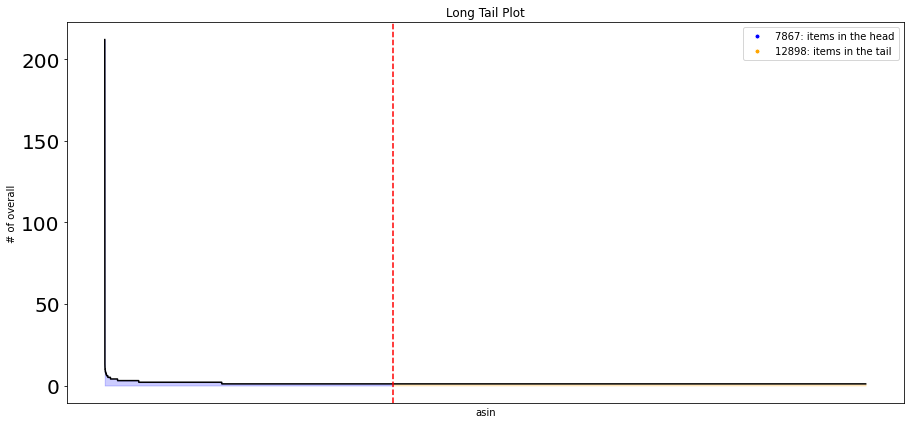

In [33]:
'Long Tail plot to show the distribution of books'
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=data_df_3_sample, 
             item_id_column="asin", 
             interaction_type="overall", 
             percentage=0.5,
             x_labels=False)
fig.savefig(os.path.join(PATH_OUTPUT,"Long Tail.png"))

In [34]:
#delete to save memory
del data_df, user_list, data_df_3_freq, sample_users

##### Creating Custom InMemory Hetro Dataset as required by PyG Models

In [35]:
'Creating label encoders for asin and revieweID as they are alphanumeric'
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
data_df_3_sample['user_id_idx'] = le_user.fit_transform(data_df_3_sample['reviewerID'].values)
data_df_3_sample['item_id_idx'] = le_item.fit_transform(data_df_3_sample['asin'].values)

In [36]:
'Unique list of books and count'
data_df_books = data_df_3_sample.groupby(['item_id_idx',
                                          'categoryLast','asin'])['overall'].count().reset_index(drop=False)

In [37]:
'Custom dataset'
#reference - https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
class AmazonUsers(InMemoryDataset):
    def __init__(self, transform=None):
        super(AmazonUsers, self).__init__('.', transform, None, None)
        
        data = HeteroData()
        
        # Book nodes
        book_mapping = {idx: i for i, idx in enumerate(data_df_books.item_id_idx)}
        
        book_categories = data_df_books['categoryLast'].str.get_dummies('|').values
        book_categories = torch.from_numpy(book_categories).to(torch.float)
        
        model = SentenceTransformer("all-MiniLM-L6-v2")
        with torch.no_grad():
            emb = model.encode(data_df_books['asin'].values, show_progress_bar=True, convert_to_tensor=True).cpu()
        
        data['books'].x = torch.cat([emb, book_categories], dim=-1)
        data['books'].num_nodes = len(book_mapping)
        
        # User nodes
        user_mapping = {idx: i for i, idx in enumerate(data_df_3_sample['reviewerID'].unique())}
        data['user'].num_nodes = len(user_mapping)
        data['user'].x = torch.eye(data['user'].num_nodes)
        
        # Edges
        src = [user_mapping[idx] for idx in data_df_3_sample['reviewerID']]
        dst = [book_mapping[idx] for idx in data_df_3_sample['item_id_idx']]
        edge_index = torch.tensor([src, dst])

        rating = torch.from_numpy(data_df_3_sample['overall'].values).to(torch.long)
        data['user', 'rates', 'books'].edge_index = edge_index
        data['user', 'rates', 'books'].edge_label = rating

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = AmazonUsers()
data = dataset[0]

Batches:   0%|          | 0/649 [00:00<?, ?it/s]

In [38]:
'Print details of nodes and edges'
data

HeteroData(
  books={
    x=[20765, 813],
    num_nodes=20765
  },
  user={
    num_nodes=975,
    x=[975, 975]
  },
  (user, rates, books)={
    edge_index=[2, 25796],
    edge_label=[25796]
  }
)

In [39]:
'Make graph undirected'
data = T.ToUndirected()(data)
del data['books', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [40]:
'Split into train, val and test data'
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'books')],
    rev_edge_types=[('books', 'rev_rates', 'user')],
)(data)

In [41]:
'Check test sample size'
test_data

HeteroData(
  books={
    x=[20765, 813],
    num_nodes=20765
  },
  user={
    num_nodes=975,
    x=[975, 975]
  },
  (user, rates, books)={
    edge_index=[2, 23217],
    edge_label=[2579],
    edge_label_index=[2, 2579]
  },
  (books, rev_rates, user)={ edge_index=[2, 23217] }
)

##### Model Training

In [42]:
'Adjustment in weight as the data is biased - see long tail graph'
weight = torch.bincount(train_data['user', 'books'].edge_label)
weight = weight.max() / weight
weight[weight == -inf] = 0
weight[weight == inf] = 0

In [43]:
'Function for early stopping'
def early_stopping(epoch, epoch_val_loss, previous_loss, count_paitence):
    """Function to calculate the stopping point based on validation loss score"""
    if epoch_val_loss - previous_loss>.2:
        count_paitence += 1
        print(colored(f'Epoch {epoch} validation set loss is greater than epoch {epoch -1} loss.','blue'))
        print(colored(f'Paitence Counter value: {count_paitence}', 'green'))
        if count_paitence >= patience:
            print(colored('Stopping early as validation score has stopped improving','magenta', attrs=['bold']))
            return ['stop']
    else:
        count_paitence = 0
    previous_loss = epoch_val_loss
    return [previous_loss, count_paitence]

In [44]:
'Model Architecture'
#Reference: https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html?highlight=GNN%20Encoder
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['books'][col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

model = Model(hidden_channels=32)

In [45]:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

In [46]:
'Model Training'
def train():
    model.train()
    optimizer.zero_grad()

    pred = model(train_data.x_dict, train_data.edge_index_dict, train_data['user', 'books'].edge_label_index)
    target = train_data['user', 'books'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [47]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict, data['user', 'books'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'books'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse), pred

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_pred = defaultdict()
test_pred = defaultdict()
val_pred = defaultdict()

train_rmse_list = []
val_rmse_list = []
test_rmse_list = []

patience = 5 # Training will stop if val loss drops continously
count_paitence = 0

for epoch in range(0, 201):
    loss = train()
    
    train_rmse, train_pred[epoch] = test(train_data)
    
    val_rmse, val_pred[epoch] = test(val_data)
    
    test_rmse, test_pred[epoch] = test(test_data)
    
    # Adding loss to list for charts
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    test_rmse_list.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f} ,Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    # Early stopping
    if epoch == 0:
        previous_loss = val_rmse

    early_stop_check = early_stopping(epoch, val_rmse, previous_loss, count_paitence)
    if early_stop_check[0] =='stop':
        break
    else:
        previous_loss = early_stop_check[0]
        count_paitence = early_stop_check[1]

Epoch: 000, Loss: 37.3805, Train: 4.4379 ,Val: 4.4710, Test: 4.4482
Epoch: 001, Loss: 33.2273, Train: 4.0111 ,Val: 4.1281, Test: 4.1015
Epoch: 002, Loss: 25.7494, Train: 3.1485 ,Val: 3.4358, Test: 3.4020
Epoch: 003, Loss: 14.1891, Train: 1.6435 ,Val: 2.2171, Test: 2.1736
Epoch: 004, Loss: 5.9759, Train: 1.0554 ,Val: 1.1309, Test: 1.1175
Epoch: 005, Loss: 19.5686, Train: 0.9070 ,Val: 1.3967, Test: 1.3606
Epoch 5 validation set loss is greater than epoch 4 loss.
Paitence Counter value: 1
Epoch: 006, Loss: 10.9261, Train: 1.4632 ,Val: 2.0672, Test: 2.0236
Epoch 6 validation set loss is greater than epoch 5 loss.
Paitence Counter value: 2
Epoch: 007, Loss: 5.5119, Train: 2.1928 ,Val: 2.6646, Test: 2.6246
Epoch 7 validation set loss is greater than epoch 6 loss.
Paitence Counter value: 3
Epoch: 008, Loss: 6.8475, Train: 2.6014 ,Val: 2.9875, Test: 2.9508
Epoch 8 validation set loss is greater than epoch 7 loss.
Paitence Counter value: 4
Epoch: 009, Loss: 9.3395, Train: 2.7310 ,Val: 3.0893, T

Epoch: 113, Loss: 2.4565, Train: 1.0837 ,Val: 1.4745, Test: 1.4604
Epoch: 114, Loss: 2.4535, Train: 1.0847 ,Val: 1.4734, Test: 1.4593
Epoch: 115, Loss: 2.4504, Train: 1.0867 ,Val: 1.4734, Test: 1.4594
Epoch: 116, Loss: 2.4472, Train: 1.0882 ,Val: 1.4728, Test: 1.4588
Epoch: 117, Loss: 2.4441, Train: 1.0881 ,Val: 1.4701, Test: 1.4562
Epoch: 118, Loss: 2.4410, Train: 1.0864 ,Val: 1.4656, Test: 1.4518
Epoch: 119, Loss: 2.4377, Train: 1.0840 ,Val: 1.4601, Test: 1.4465
Epoch: 120, Loss: 2.4344, Train: 1.0821 ,Val: 1.4553, Test: 1.4417
Epoch: 121, Loss: 2.4311, Train: 1.0814 ,Val: 1.4518, Test: 1.4384
Epoch: 122, Loss: 2.4278, Train: 1.0816 ,Val: 1.4496, Test: 1.4362
Epoch: 123, Loss: 2.4244, Train: 1.0821 ,Val: 1.4477, Test: 1.4344
Epoch: 124, Loss: 2.4209, Train: 1.0823 ,Val: 1.4452, Test: 1.4320
Epoch: 125, Loss: 2.4174, Train: 1.0817 ,Val: 1.4419, Test: 1.4288
Epoch: 126, Loss: 2.4139, Train: 1.0807 ,Val: 1.4379, Test: 1.4249
Epoch: 127, Loss: 2.4103, Train: 1.0795 ,Val: 1.4338, Test: 1.

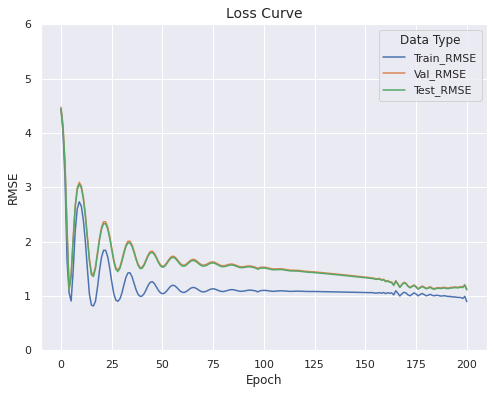

In [49]:
'Plot Loss Curve'
plot_curve = pd.DataFrame({"Train_RMSE": train_rmse_list,
                           "Val_RMSE": val_rmse_list,
                           "Test_RMSE": test_rmse_list})
plot_curve = plot_curve.reset_index(drop=False)
plot_curve = plot_curve.melt(id_vars ="index")
plot_curve.rename(columns={"index":"Epoch", "value" : "RMSE", "variable" :"Data Type"}, 
                  inplace =True)
plot_curve.head()

fig = plt.figure(figsize=(8, 6))  # figure size with ratio 8:6
sns.set(style='darkgrid', )
sns.lineplot(x="Epoch", y="RMSE", hue="Data Type", data=plot_curve)
plt.ylim(0, 6)
plt.title("Loss Curve", fontsize=14)
plt.show()
fig.savefig(os.path.join(PATH_OUTPUT,"Loss Curve.png"))

##### Sample Recommendation Example

In [50]:
'User and book mapping'
user_mapping = {idx: i for i, idx in enumerate(data_df_3_sample['reviewerID'].unique())}
book_mapping = {idx: i for i, idx in enumerate(data_df_books.item_id_idx)}

In [51]:
USERID = int(10) # Sample the user id
NUM_BOOKS = int(5) # Number of recommendations

In [52]:
num_books = len(data['books'].x)
row = torch.tensor([USERID] * num_books)
col = torch.arange(num_books)
edge_label_index = torch.stack([row, col], dim=0)
pred = model(data.x_dict, data.edge_index_dict, edge_label_index)
pred = pred.clamp(min=0, max=5)
idx_max = torch.topk(pred, NUM_BOOKS).indices
print('Recommended Books for User ' + str(USERID))
for i in idx_max:
    bookId = book_mapping[int(i)]
    print(data_df_books.loc[bookId].asin, data_df_books.loc[bookId].categoryLast)

Recommended Books for User 10
000617454X  Contemporary
0001720392  Classics
0006499627  Thriller & Suspense
0006755232  Teen &amp; Young Adult
0002241277  Thrillers & Suspense


### Evaluation Metrics

##### Recall@K and Precision@K

In [53]:
'Recall and Precision'
test_actual = np.vstack((test_data['user','books'].edge_label_index,test_data['user','books'].edge_label))
test_predicted = pd.DataFrame(np.vstack((test_actual, test_pred[epoch])).T, 
                              columns = ['UserID','BookID','actual_rating','predicted_rating'])

test_predicted['UserID'] = test_predicted['UserID'].apply(lambda x: int(x))
test_predicted['BookID'] = test_predicted['BookID'].apply(lambda x: int(x))
test_predicted['predicted_rating'] = test_predicted['predicted_rating'].apply(lambda x: round(x,0))
test_predicted.to_pickle(os.path.join(PATH_OUTPUT,'test_predicted.pkl'))
test_predicted.head()

,UserID,BookID,actual_rating,predicted_rating
0,555,17592,5.0,5.0
1,961,19578,4.0,4.0
2,678,17331,5.0,4.0
3,456,2842,5.0,3.0
4,699,17942,5.0,4.0


In [54]:
'Convert to dictionary'
user_pred_true = defaultdict(list)
for i in range(0, len(test_predicted)):
    actual_rating = test_predicted.loc[i,'actual_rating']
    predicted_rating =   test_predicted.loc[i,'predicted_rating']
    userId = test_predicted.loc[i,'UserID']
    user_pred_true[userId].append((predicted_rating, actual_rating))

In [55]:
'Calculate Precision and Recall'
# Reference: https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k
# Distinction between relevant and recommended is discussed in detail in model document
threshold = 4
precision = dict()
recall = dict()
avg_precision = dict()
avg_recall = dict()
for k in range(1,11):
    for user_id, user_ratings in user_pred_true.items():

        # sorted ratings
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # count of relevant items
        count_relevant = sum((actual_rating >= threshold) for (predicted_rating, actual_rating) in user_ratings)
        # count of recommended items in top k
        count_recommended_k = sum((predicted_rating >= threshold) for (predicted_rating, actual_rating) in user_ratings[:k])
        # count of relevant and recommended items in top k
        count_relevant_and_recommended_k = sum(
            ((actual_rating >= threshold) and (predicted_rating >= threshold))
            for (predicted_rating, actual_rating) in user_ratings[:k]
        )
        # Precision@K and # Recall@K
        precision[user_id] = count_relevant_and_recommended_k /count_recommended_k if count_recommended_k != 0 else 0
        recall[user_id] = count_relevant_and_recommended_k /count_relevant if count_relevant != 0 else 0
    
    avg_precision[k] = sum(prec for prec in precision.values()) / len(precision)
    avg_recall[k] = sum(rec for rec in recall.values()) / len(recall)

avg_recall_df = pd.DataFrame(list(avg_recall.items()),columns = ['k','avg_recall']) 
avg_precision_df = pd.DataFrame(list(avg_precision.items()),columns = ['k','avg_precision']) 

avg_precision_df.to_pickle(os.path.join(PATH_OUTPUT,'avg_precision_df.pkl'))
avg_recall_df.to_pickle(os.path.join(PATH_OUTPUT,'avg_recall_df.pkl'))

print(avg_precision_df)
print("--------------------")
print(avg_recall_df)

    k  avg_precision
0   1       0.734257
1   2       0.727330
2   3       0.725441
3   4       0.724601
4   5       0.725357
5   6       0.725063
6   7       0.724763
7   8       0.724313
8   9       0.724348
9  10       0.724446
--------------------
    k  avg_recall
0   1    0.427994
1   2    0.565127
2   3    0.616631
3   4    0.639690
4   5    0.655275
5   6    0.663480
6   7    0.669517
7   8    0.673010
8   9    0.675711
9  10    0.677804


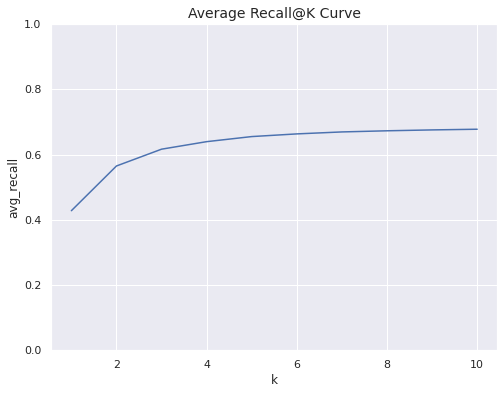

In [56]:
'Plot Recall Curve'
fig = plt.figure(figsize=(8, 6))  # figure size with ratio 8:6
sns.set(style='darkgrid', )
sns.lineplot(x="k", y="avg_recall", data=avg_recall_df)
plt.ylim(0, 1)
plt.title("Average Recall@K Curve", fontsize=14)
plt.show()
fig.savefig(os.path.join(PATH_OUTPUT,"Average Recall@K Curve.png"))

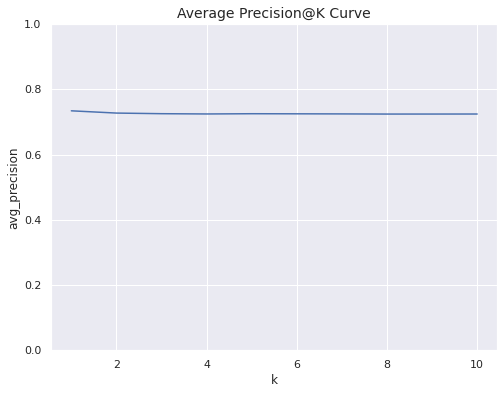

In [57]:
'Plot Precision Curve'
fig = plt.figure(figsize=(8, 6))  # figure size with ratio 8:6
sns.set(style='darkgrid', )
sns.lineplot(x="k", y="avg_precision", data=avg_precision_df)
plt.ylim(0, 1)
plt.title("Average Precision@K Curve", fontsize=14)
plt.show()
fig.savefig(os.path.join(PATH_OUTPUT,"Average Precision@K Curve.png"))

##### Coverage & Personalization Scores


In [58]:
# Source : recmetric library
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [59]:
## Suggesting 10 books from the graph model
graph_model = test_predicted.pivot_table(index='UserID', columns='BookID', values='predicted_rating').fillna(0)
test_predicted_id = test_predicted.copy().groupby('UserID', as_index=False)['BookID'].agg({'actual_rating':
                                                                                        (lambda x: list(set(x)))})
test_predicted_id = test_predicted_id.set_index("UserID")

graph_model_recs = [] = []
for user in test_predicted_id.index:
    graph_predictions = get_users_predictions(user, 10, graph_model)
    graph_model_recs.append(graph_predictions)
        
test_predicted_id['graph_predictions'] = graph_model_recs

## Suggesting the most bought books as recommendation
popular_recomm = data_df_3_sample.item_id_idx.value_counts().head(10).index.tolist()

pop_recomm = []
for user in test_predicted_id.index:
    pop_recomm.append(popular_recomm)
        
test_predicted_id['pop_predictions'] = pop_recomm
test_predicted_id.head()

## Suggesting 10 random books as recommendation
ran_recomm = []
for user in test_predicted_id.index:
    ran_recomm.append(data_df_3_sample.item_id_idx.sample(10).values.tolist())
        
test_predicted_id['random_predictions'] = ran_recomm

test_predicted_id.head()

,actual_rating,graph_predictions,pop_predictions,random_predictions
UserID,,,,
0,"[5365, 1894]","[5365, 1894, 0, 13965, 13922, 13923, 13942, 13...","[20333, 3141, 2071, 3136, 9282, 3125, 11974, 1...","[8143, 880, 5911, 847, 5266, 5174, 5670, 10008..."
1,[8148],"[8148, 0, 13965, 13922, 13923, 13942, 13945, 1...","[20333, 3141, 2071, 3136, 9282, 3125, 11974, 1...","[20208, 1291, 14874, 9084, 9332, 8570, 15263, ..."
2,"[5664, 10566, 2445, 12175, 16368, 180, 20348]","[10566, 5664, 12175, 20348, 2445, 180, 16368, ...","[20333, 3141, 2071, 3136, 9282, 3125, 11974, 1...","[6115, 3543, 8568, 9241, 12019, 81, 11899, 181..."
3,"[20578, 10755, 1187, 134, 16368]","[1187, 20578, 10755, 16368, 134, 13966, 13923,...","[20333, 3141, 2071, 3136, 9282, 3125, 11974, 1...","[17955, 15826, 1509, 13621, 4673, 16472, 19668..."
4,"[7843, 2179, 8005, 4855]","[8005, 7843, 4855, 2179, 13966, 13923, 13942, ...","[20333, 3141, 2071, 3136, 9282, 3125, 11974, 1...","[4992, 14180, 15069, 10415, 19557, 14365, 8394..."


In [60]:
catalog = data_df_3_sample.item_id_idx.unique().tolist()
random_cat_coverage = recmetrics.prediction_coverage(ran_recomm, catalog)
pop_cat_coverage = recmetrics.prediction_coverage(pop_recomm, catalog)
graph_cat_coverage = recmetrics.prediction_coverage(graph_model_recs, catalog)

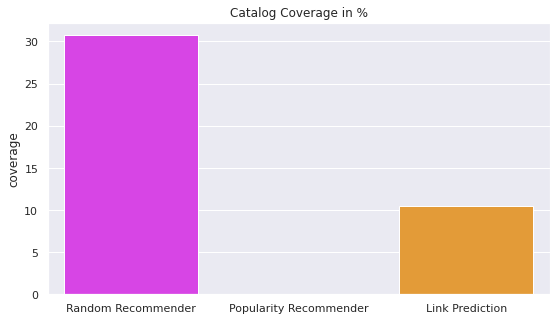

In [61]:
# plot of prediction coverage
coverage_scores = [random_cat_coverage, pop_cat_coverage, graph_cat_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Link Prediction']

fig = plt.figure(figsize=(9, 5))
recmetrics.coverage_plot(coverage_scores, model_names)
fig.savefig(os.path.join(PATH_OUTPUT,"Catalog Coverage.png"))

In [62]:
# Personalization Score
personalization = recmetrics.personalization(test_predicted_id.graph_predictions.to_list())
print('Personalization Score', personalization)

Personalization Score 0.49691920170509585


In [63]:
# Prediction Coverage
prediction_coverage = recmetrics.prediction_coverage(test_predicted_id.graph_predictions.to_list(), catalog)
print('Prediction Coverage', prediction_coverage)

Prediction Coverage 10.51


In [64]:
# Save everything
torch.save(data, os.path.join(PATH_OUTPUT, 'data'))
torch.save(model.state_dict(), os.path.join(PATH_OUTPUT, 'link_prediction.pt'))
data_df_3_sample.to_pickle(os.path.join(PATH_OUTPUT, 'data_sample.pkl'))
data_df_books.to_pickle(os.path.join(PATH_OUTPUT,'data_books.pkl'))
test_predicted_id.to_pickle(os.path.join(PATH_OUTPUT,'test_predicted_user_id.pkl'))